# Part A: Classification Problem

This project aims at building neural networks to classify the Cardiotocography dataset containing measurements of fetal heart rate (FHR) and uterine contraction (UC) features on 2126 cardiotocograms classified by expert obstetricians \[1\]. The dataset can be obtained from: https://archive.ics.uci.edu/ml/datasets/Cardiotocography.

The cardiotocograms were classified by three expert obstetricians and a consensus classification label with respect to a morphologic pattern and to a fetal state (N: Normal; S: Suspect; P: Pathologic) was assigned to each of them. The aim is to predict the N, S and P class labels in the test dataset after training the neural network on the training dataset.

Read the data from the file: ctg_data_cleaned.csv. Each data sample is a row of 23 values: 21 input attributes and 2 class labels (use the NSP label with values 1, 2 and 3 and ignore the other). First, divide the dataset in 70:30 ratio for training and testing. Use 5-fold cross-validation on the training dataset for selecting the optimal model, and test it on the testing data.

\[1\] Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of
Cardiotocograms. J Matern Fetal Med 5:311-318.

In [57]:
# import relevant libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import time

In [58]:
# configurations
seed = 0  # for reproducible results when randomness is introduced
tf.random.set_seed(seed)  # since shuffle=True in model.fit()

In [59]:
# load data
dataframe = pd.read_csv('data/ctg_data_cleaned.csv')
dataframe.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,126,2,0,120,137,121,73,1,9,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,198,6,1,141,136,140,12,0,6,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,198,5,1,141,135,138,13,0,6,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,170,11,0,137,134,137,13,1,6,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,170,9,0,137,136,138,11,1,2,1


In [60]:
# show basic information of data
dataframe.describe()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,4.509878,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,3.026883,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,2.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,4.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,7.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,10.000000,3.000000


In [61]:
# drop other class label since we are using NSP label
dataframe = dataframe.drop(columns='CLASS')
dataframe.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,1


In [62]:
labels = dataframe['NSP']
features = dataframe.drop(columns='NSP')

del dataframe

In [63]:
labels.head()

0    2
1    1
2    1
3    1
4    1
Name: NSP, dtype: int64

In [64]:
features.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,64,62,126,2,0,120,137,121,73,1
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,130,68,198,6,1,141,136,140,12,0
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,130,68,198,5,1,141,135,138,13,0
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,117,53,170,11,0,137,134,137,13,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,117,53,170,9,0,137,136,138,11,1


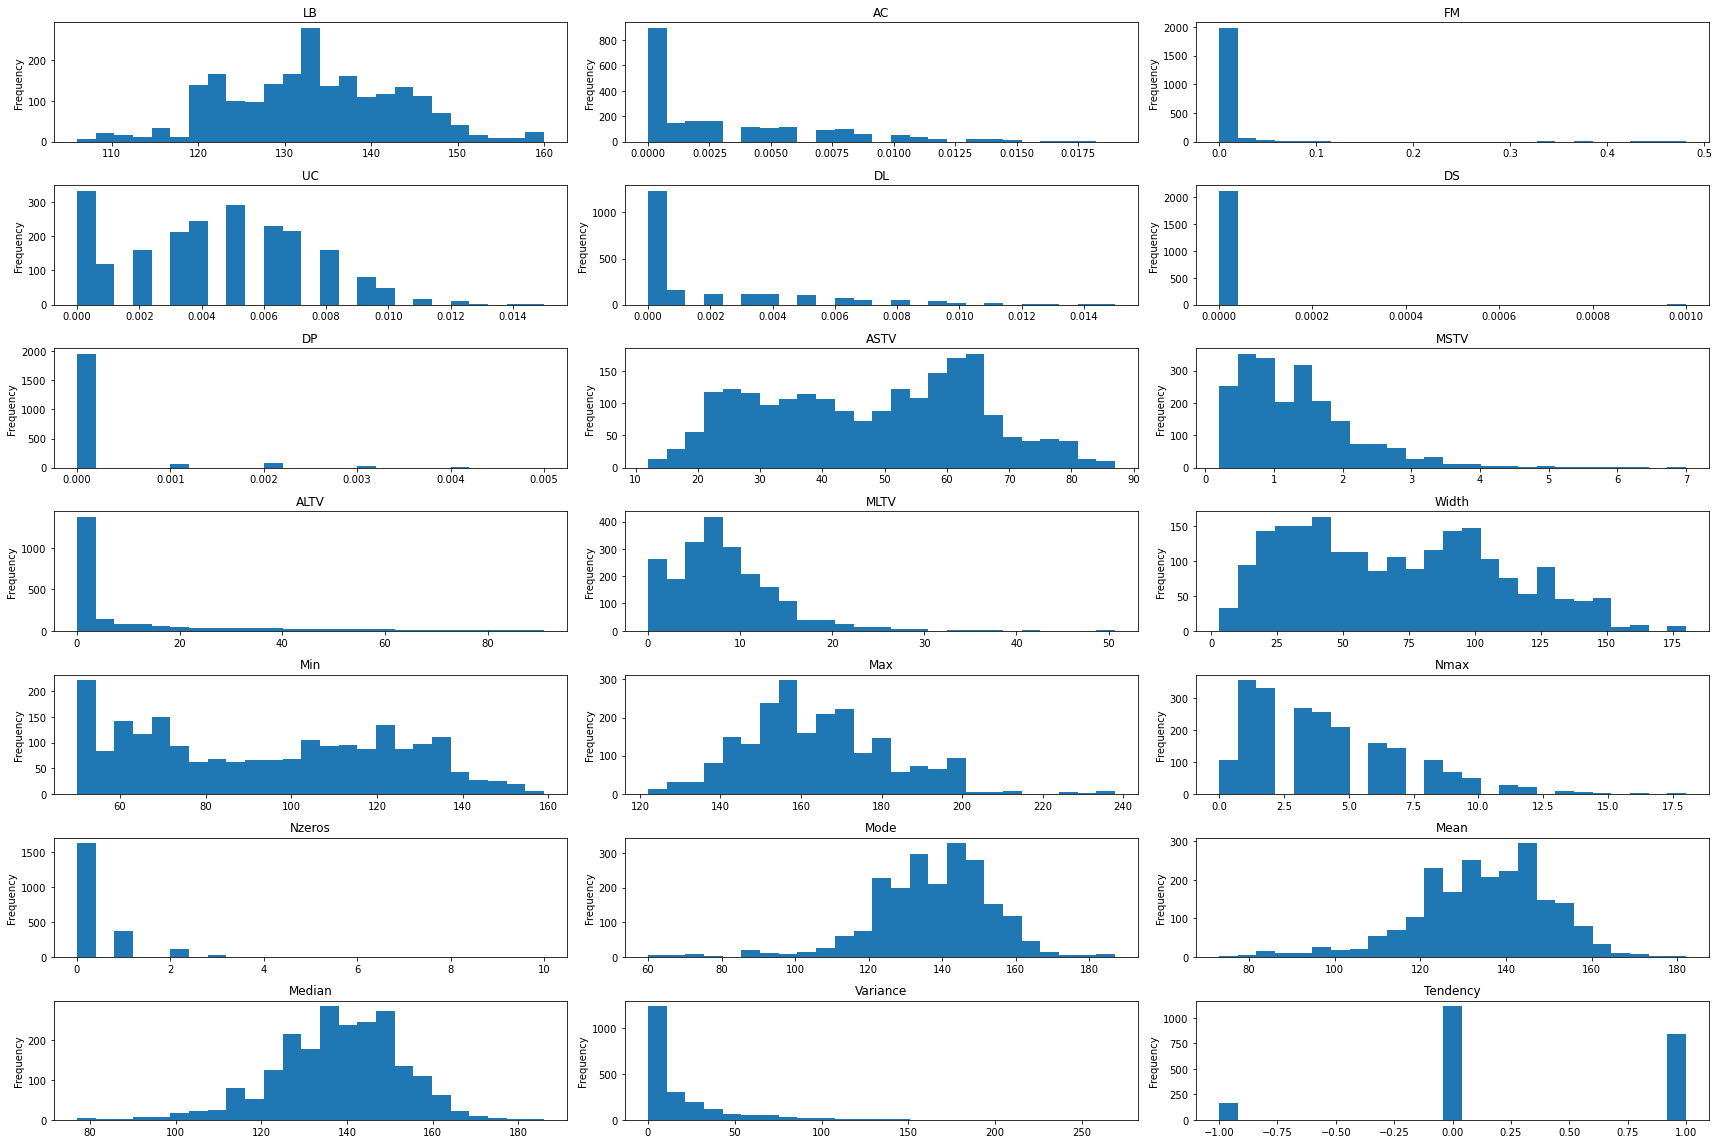

In [65]:
# show distribution for each feature
figure, axes = plt.subplots(nrows=7, ncols=3, figsize=(24, 16))

for index, column in enumerate(features.columns):
    feature = features[column]

    row_num = index // 3
    col_num = index % 3

    feature.plot.hist(bins=25, ax=axes[row_num, col_num])
    axes[row_num, col_num].set_title(column)

figure.tight_layout()

plt.savefig('output/a.png')

del figure

It seems that some of the features follow normal distribution, so let's normalise the data by subtracting mean and dividing by standard deviation to get standard score.

In [66]:
scaler = StandardScaler()
features = scaler.fit_transform(features)
features = pd.DataFrame(features)

del scaler

In [67]:
# let labels start from 0 to correspond to list index
labels -= 1
print(labels.unique())

[1 0 2]


In [68]:
# divide the dataset in 70:30 ratio for training and testing
train_features, test_features, train_labels, test_labels = train_test_split(
    features,
    labels,
    test_size=0.3,
    random_state=seed,
)

In [69]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
994,-0.437449,0.212626,-0.20321,-1.142949,-0.638438,-0.057476,-0.268754,-1.162976,-0.150373,-0.480991,...,-0.268212,0.149578,-0.335865,-0.362263,-0.458444,-0.271839,-0.103306,-0.282808,-0.511138,-0.524526
1618,0.883886,-0.046128,0.86849,-0.803434,1.388924,-0.057476,1.426711,1.105948,2.227792,-0.535361,...,1.092629,-0.899376,0.890448,0.994270,-0.458444,0.216638,-1.514474,0.616025,2.457366,1.112980
177,-1.453861,1.247640,-0.20321,0.215111,-0.300544,-0.057476,-0.268754,-0.988443,0.529103,-0.535361,...,1.503448,-0.831702,1.893794,1.672537,-0.458444,-0.332898,-0.167450,-0.213667,0.041142,-0.524526
519,-0.742373,1.247640,0.65415,0.215111,-0.638438,-0.057476,-0.268754,-0.290313,0.189365,-0.535361,...,1.965620,-1.440771,1.893794,1.672537,-0.458444,-0.271839,0.089126,-0.282808,-0.200481,-0.524526
745,0.883886,-0.563635,-0.20321,0.215111,3.416285,-0.057476,-0.268754,-1.395686,2.567530,-0.535361,...,1.888592,-1.474609,1.670828,2.689937,0.958201,0.338757,-0.488170,-0.213667,1.836051,-0.524526


1. Design a feedforward neural network which consists of an input layer, one hidden layer of 10 neurons with ReLU activation function, and an output softmax layer. Assume a learning rate α = 0.01, L<sub>2</sub> regularization with weight decay parameter β = 10<sup>-6</sup> , and batch size = 32. Use appropriate scaling of input features.

In [70]:
# input layer params
num_features = len(features.columns)

# hidden layer params
num_hidden_neurons = 10
hidden_activation = 'relu'
weight_decay_parameter = 10**-6

# output layer params
num_classes = labels.nunique()  # 3: N, S, P
output_activation = 'softmax'

del features
del labels

In [71]:
def get_3_layer_nn(num_neurons: int, decay_param: float) -> tf.keras.Sequential:
    '''
    Generates a 3-layer fully-connected neural network.
        layer 1 - input layer
        layer 2 - hidden layer
        layer 3 - output layer (softmax)

    :params:
    - num_neurons (int): number of neurons in the hidden layer
    - decay_param (float): weight decay parameter for L_2 loss

    :return:
    - (tf.keras.Sequential)
    '''
    input_layer = tf.keras.layers.InputLayer(
        input_shape=num_features,
    )

    hidden_layer = tf.keras.layers.Dense(
        num_neurons,
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.l2(l=decay_param),
    )

    output_layer = tf.keras.layers.Dense(
        num_classes,
        activation=output_activation,
    )

    model = tf.keras.Sequential([
        input_layer,
        hidden_layer,
        output_layer,
    ])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['accuracy'],
    )

    return model

In [72]:
# training params
learning_rate = 0.01
batch_size = 32
num_epochs_per_step = 50  # 1 epoch per step is too unstable, so take average over multiple epochs

In [73]:
# define train function that train for a fixed number of epochs
def train(
    model: tf.keras.Sequential,
    train_features: pd.DataFrame,
    train_labels: pd.Series,
    test_features: pd.DataFrame,
    test_labels: pd.Series,
    num_epochs: int = 1000,
) -> tuple:
    '''
    Train a model using the given data for a fixed number of epochs.
    
    :params:
    - model (tf.keras.Sequential): the model to be trained
    - train_features (pd.DataFrame): features for model to train on
    - train_labels (pd.Series): labels for model to train on
    - test_features (pd.DataFrame): features for model to use for validation and evaluation
    - test_labels (pd.Series): labels for model to use for validation and evaluation
    - num_epochs (int): the number of epochs to train the model for
    
    :return:
    tuple consisting of
    - model that has been trained
    - training history (dict with keys: 'loss', 'val_loss', 'accuracy', 'val_accuracy)
    - evaluation results (dict with keys: 'loss', 'accuracy', 'num_epochs')
    '''
    train_history = model.fit(
        x=train_features,
        y=train_labels,
        batch_size=batch_size,
        epochs=num_epochs,
        verbose=0,  # not showing training details
        validation_data=(test_features, test_labels),
        shuffle=True,
    )

    results = model.evaluate(
        test_features,
        test_labels,
        batch_size=batch_size,
        return_dict=True,
    )
    results['num_epochs'] = num_epochs

    return model, train_history.history, results

In [90]:
# define train function that checks for number of epochs till convergence
def train_early_stop(
    model: tf.keras.Sequential,
    train_features: pd.DataFrame,
    train_labels: pd.Series,
    test_features: pd.DataFrame,
    test_labels: pd.Series,
    batch_size: int = 32,
) -> tuple:
    '''
    Train a model using the given data till convergence.
    
    :params:
    - model (tf.keras.Sequential): the model to be trained
    - train_features (pd.DataFrame): features for model to train on
    - train_labels (pd.Series): labels for model to train on
    - test_features (pd.DataFrame): features for model to use for validation and evaluation
    - test_labels (pd.Series): labels for model to use for validation and evaluation
    - batch_size (int): size of each batch of input data into model for mini-batch gradient descent
    
    :return:
    tuple consisting of
    - model that has been trained
    - training history (dict with keys: 'loss', 'val_loss', 'accuracy', 'val_accuracy)
    - evaluation results (dict with keys: 'loss', 'accuracy', 'num_epochs')
    '''
    previous_average_loss = 3
    current_average_loss = 2
    next_average_loss = 1
    
    stop_early = False

    num_epochs = 0  # count actual total number of training epochs
    history = {  # fit multiple times, so need to store history
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': [],
    }

    while not stop_early:   
        train_history = model.fit(
            x=train_features,
            y=train_labels,
            batch_size=batch_size,
            epochs=num_epochs_per_step,
            verbose=0,  # not showing training details
            validation_data=(test_features, test_labels),
            shuffle=True,
        )

        num_epochs += num_epochs_per_step

        for metric, values in train_history.history.items():
            history[metric] += values

        previous_average_loss, current_average_loss = current_average_loss, next_average_loss
        next_average_loss = sum(train_history.history['val_loss']) / num_epochs_per_step
        
        stop_early = current_average_loss < previous_average_loss and \
            current_average_loss < next_average_loss  # early stopping at minimum loss
        
        # final model overfits a little since it stops 50 epochs after minimum test error

    results = model.evaluate(
        test_features,
        test_labels,
        batch_size=batch_size,
        return_dict=True,
    )
    results['num_epochs'] = num_epochs
    
    return model, history, results

In [75]:
# define function to print results after training a model
def print_results(results: dict):
    '''
    Print evaluation scores and number of epochs.
    Loss and accuracy values are printed to 4 decimal places.
    
    :params:
    - results (dict): holds evaluation results - keys: 'loss', 'accuracy', 'num_epochs'
    '''
    loss = results['loss']
    accuracy = results['accuracy']
    num_epochs = results['num_epochs']
    
    print(f'test loss: {loss:.4f}, test accuracy: {accuracy:.4f}')
    print(f'number of epochs to reach minimum test error: {num_epochs}')

In [76]:
# define function to plot loss and accuracy curves for usage later
def plot_loss_accuracy_curves(num_epochs: int, history: dict, image_path: str = None):
    '''
    Plots loss curve and accuracy curve side-by-side.
    
    :params:
    - total_num_epochs (int): total number of epochs for model to get minimal test error
    - history (dict): history of loss and accuracy values at each epoch
        - keys: 'loss', 'val_loss', 'accuracy', 'val_accuracy'
    - image_path (str): save figure as image to this file path (default: None / no save)
    '''
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title('loss')
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='test')
    loss_axis.legend()

    accuracy_axis.set_title('accuracy')
    accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='test')
    accuracy_axis.legend()

    if image_path is not None:
        plt.savefig(image_path)

a) Use the training dataset to train the model and plot accuracies on training and testing data against training epochs.

b) State the approximate number of epochs where the test error begin to converge.

In [77]:
# get model
model = get_3_layer_nn(num_hidden_neurons, weight_decay_parameter)
model.summary()

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 10)                220       
_________________________________________________________________
dense_162 (Dense)            (None, 3)                 33        
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________


In [78]:
# train model
model, history, results = train_early_stop(model, train_features, train_labels, test_features, test_labels)

del model

20/20 [==============================] - 0s 1ms/step - loss: 0.6514 - accuracy: 0.8934


In [79]:
# check evaluation scores
print_results(results)

test loss: 0.6514, test accuracy: 0.8934
number of epochs to reach minimum test error: 3550


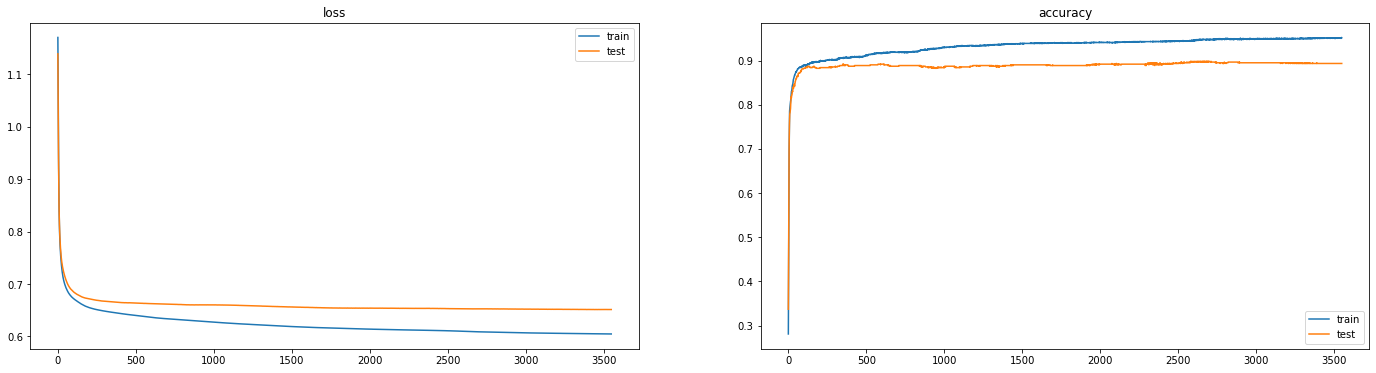

In [80]:
plot_loss_accuracy_curves(results['num_epochs'], history, 'output/a_1a.png')


del results
del history

In [81]:
# use 5-fold cross-validation for selecting optimal model
num_splits = 5
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=seed)

2. Find the optimal batch size by training the neural network and evaluating the performances for different batch sizes.

Note: use this optimal batch size for the rest of the experiments.

a) Plot cross-validation accuracies against the number of epochs for different batch sizes. Limit search space to batch sizes {4,8,16,32,64}. Plot the time taken to train the network for one epoch against different batch sizes

In [82]:
# training params

# actual number of epochs till convergence should be used,
# but it is too time consuming with cross validation involved
num_epochs = 1000
batch_sizes = [4, 8, 16, 32, 64]

In [83]:
batch_sizes_info = {batch_size: {} for batch_size in batch_sizes}

for batch_size in batch_sizes:
    print(f'trying out batch size of {batch_size}')
    time_taken = 0

    best_fold = 0
    best_results = {'loss': 1, 'accuracy': 0}
    best_history = None

    # 5-fold cross validation using training set
    splits = kfold.split(train_features, train_labels)
    for fold_index, (train_indices, val_indices) in enumerate(splits):
        print(f'working on fold {fold_index}')
        model = get_3_layer_nn(num_hidden_neurons, weight_decay_parameter)

        train_features_subset = train_features.iloc[train_indices]
        train_labels_subset = train_labels.iloc[train_indices]

        val_features = train_features.iloc[val_indices]
        val_labels = train_labels.iloc[val_indices]

        start_time = time.perf_counter()
        train_history = model.fit(
            x=train_features_subset,
            y=train_labels_subset,
            batch_size=batch_size,
            epochs=num_epochs,
            verbose=0,  # not showing training details
            validation_data=(val_features, val_labels),
            shuffle=True,
        )
        time_taken += (time.perf_counter() - start_time)

        results = model.evaluate(
            test_features,
            test_labels,
            batch_size=batch_size,
            return_dict=True,
        )

        if results['accuracy'] > best_results['accuracy']:
            best_fold = fold_index
            best_model = model
            best_results = results
            best_history = train_history

    loss = best_results['loss']
    accuracy = best_results['accuracy']
    print(f'best fold: {best_fold}, loss: {loss:.4f}, accuracy: {accuracy:.4f}')
    
    batch_sizes_info[batch_size]['epoch_time_taken'] = time_taken / (num_splits * num_epochs)
    batch_sizes_info[batch_size]['model'] = best_model
    batch_sizes_info[batch_size]['results'] = results
    batch_sizes_info[batch_size]['history'] = best_history.history

trying out batch size of 4
working on fold 0
160/160 [==============================] - 0s 996us/step - loss: 0.6557 - accuracy: 0.8950
working on fold 1
160/160 [==============================] - 0s 965us/step - loss: 0.6346 - accuracy: 0.9185
working on fold 2
160/160 [==============================] - 0s 962us/step - loss: 0.6462 - accuracy: 0.9013
working on fold 3
160/160 [==============================] - 0s 997us/step - loss: 0.6484 - accuracy: 0.9028
working on fold 4
160/160 [==============================] - 0s 948us/step - loss: 0.6579 - accuracy: 0.8950
best fold: 1, loss: 0.6346, accuracy: 0.9185
trying out batch size of 8
working on fold 0
80/80 [==============================] - 0s 1ms/step - loss: 0.6546 - accuracy: 0.8934
working on fold 1
80/80 [==============================] - 0s 1ms/step - loss: 0.6506 - accuracy: 0.8997
working on fold 2
80/80 [==============================] - 0s 1ms/step - loss: 0.6541 - accuracy: 0.8934
working on fold 3
80/80 [================

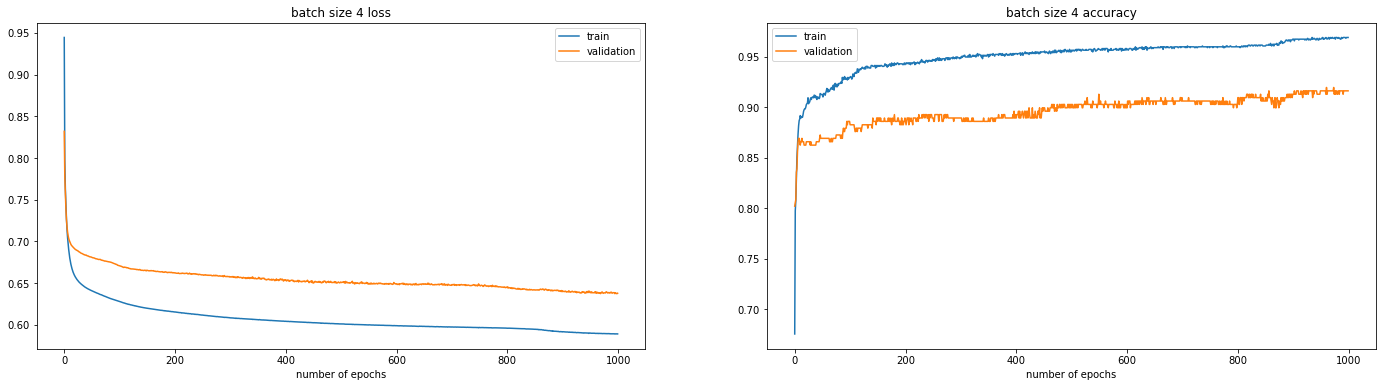

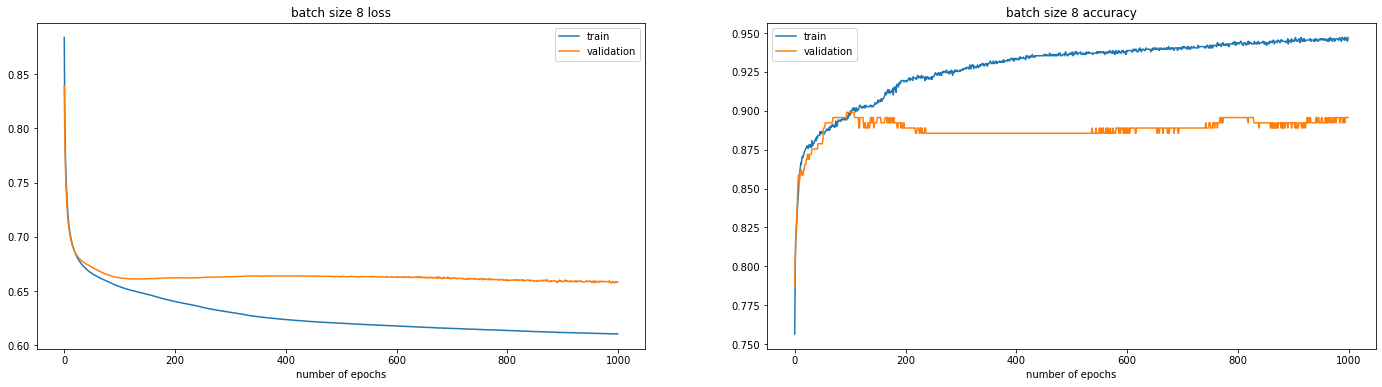

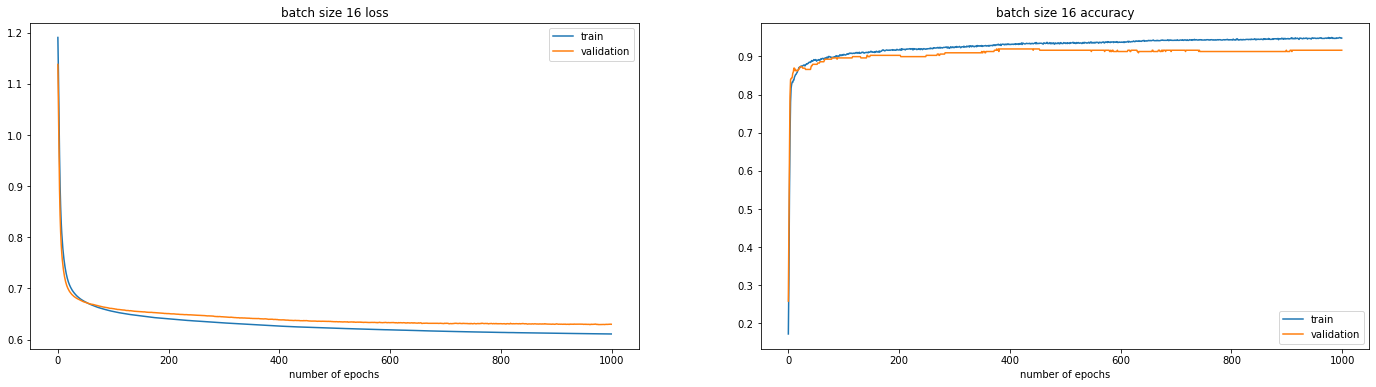

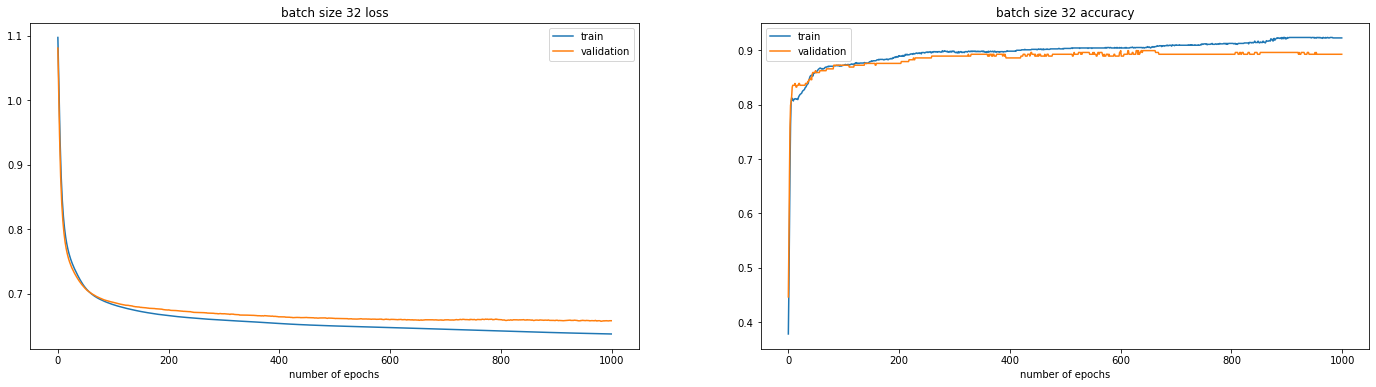

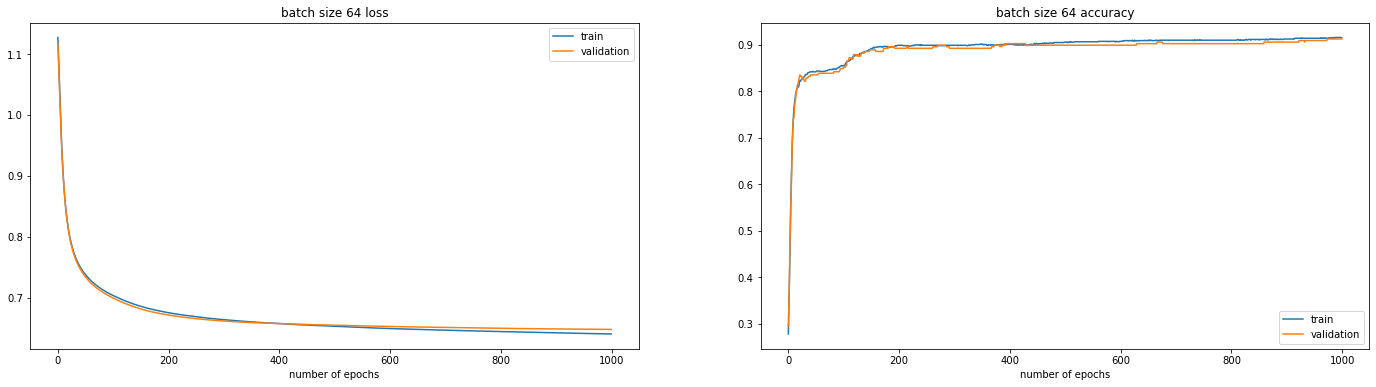

In [84]:
# plot loss and accuracy curves
for batch_size, info in batch_sizes_info.items():   
    history = info['history']
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title(f'batch size {batch_size} loss')
    
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='validation')
    
    loss_axis.legend()
    loss_axis.set_xlabel('number of epochs')

    accuracy_axis.set_title(f'batch size {batch_size} accuracy')
    
    accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='validation')
    
    accuracy_axis.legend()
    accuracy_axis.set_xlabel('number of epochs')

    plt.savefig(f'output/a_2a1_batch_size_{batch_size}.png')

print()

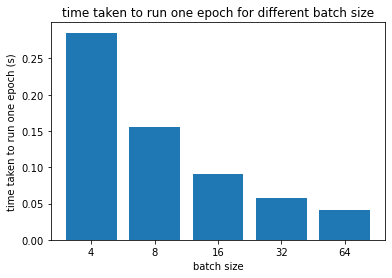

In [85]:
# plot time taken for one epoch for each batch size
batch_sizes = []
epoch_time_taken_list = []

for batch_size, info in batch_sizes_info.items():
    batch_sizes.append(batch_size)
    epoch_time_taken_list.append(info['epoch_time_taken'])
    
batch_size_position = [index for index in range(len(batch_sizes))]

plt.bar(batch_size_position, epoch_time_taken_list)
plt.xticks(batch_size_position, batch_sizes)

plt.xlabel('batch size')
plt.ylabel('time taken to run one epoch (s)')

plt.title('time taken to run one epoch for different batch size')
plt.savefig('output/a_2a2.png')
print()

In [86]:
del batch_sizes_info

b) Select the optimal batch size and state reasons for your selection.

I would go with batch size of 64. It requires a least amount of time for one epoch of training. In addition, based on the loss curves, it seems that using a larger batch size reduce the likelihood of overfitting. The trade-off is in accuracy, but the reduction of accuracy is only slightly lower. Also, the learning rate is supposed to be adjusted with batch size, but it was not, so it was not a fair comparison. [example](https://stackoverflow.com/a/53046624/9171260)

c) Plot the train and test accuracies against epochs for the optimal batch size.

In [87]:
optimal_batch_size = 64

In [92]:
# get model
model = get_3_layer_nn(num_hidden_neurons, weight_decay_parameter)

In [93]:
# train model on entire training set
model, history, results = train_early_stop(
    model,
    train_features,
    train_labels,
    test_features,
    test_labels,
    batch_size=optimal_batch_size,
)

del model

10/10 [==============================] - 0s 1ms/step - loss: 0.6598 - accuracy: 0.8903


In [94]:
# check evaluation scores
print_results(results)

test loss: 0.6598, test accuracy: 0.8903
number of epochs to reach minimum test error: 5650


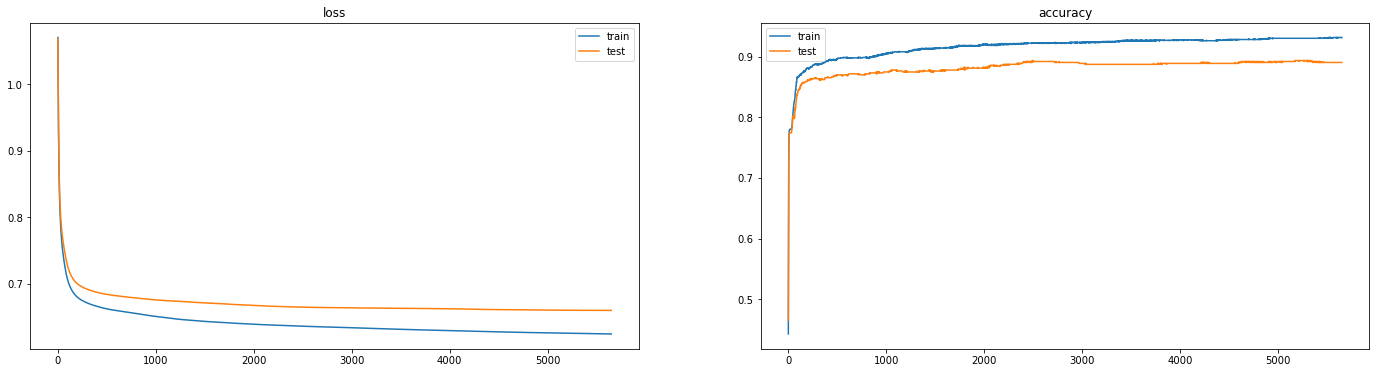

In [95]:
plot_loss_accuracy_curves(results['num_epochs'], history, 'output/a_2c.png')

del results
del history

3. Find the optimal number of hidden neurons for the 3-layer network designed in part (2).

a) Plot the cross-validation accuracies against the number of epochs for different
number of hidden-layer neurons. Limit the search space of number of neurons to
{5,10,15,20,25}.

In [96]:
# training params

num_hidden_neurons_list = [5, 10, 15, 20, 25]

In [97]:
num_neurons_info = {num_neurons: {} for num_neurons in num_hidden_neurons_list}

for num_hidden_neurons in num_hidden_neurons_list:
    print(f'trying out {num_hidden_neurons} neurons in hidden layer')

    best_fold = 0
    best_results = {'loss': 1, 'accuracy': 0}
    best_history = None

    # 5-fold cross validation using training set
    splits = kfold.split(train_features, train_labels)
    for fold_index, (train_indices, val_indices) in enumerate(splits):
        print(f'working on fold {fold_index}')
        model = get_3_layer_nn(num_hidden_neurons, weight_decay_parameter)

        train_features_subset = train_features.iloc[train_indices]
        train_labels_subset = train_labels.iloc[train_indices]

        val_features = train_features.iloc[val_indices]
        val_labels = train_labels.iloc[val_indices]

        train_history = model.fit(
            x=train_features_subset,
            y=train_labels_subset,
            batch_size=optimal_batch_size,
            epochs=num_epochs,
            verbose=0,  # not showing training details
            validation_data=(val_features, val_labels),
            shuffle=True,
        )

        results = model.evaluate(
            test_features,
            test_labels,
            batch_size=optimal_batch_size,
            return_dict=True,
        )

        if results['accuracy'] > best_results['accuracy']:
            best_fold = fold_index
            best_model = model
            best_results = results
            best_history = train_history

    loss = best_results['loss']
    accuracy = best_results['accuracy']
    print(f'best fold: {best_fold}, loss: {loss:.4f}, accuracy: {accuracy:.4f}')
    
    num_neurons_info[num_hidden_neurons]['model'] = best_model
    num_neurons_info[num_hidden_neurons]['results'] = results
    num_neurons_info[num_hidden_neurons]['history'] = best_history

trying out 5 neurons in hidden layer
working on fold 0
10/10 [==============================] - 0s 1ms/step - loss: 0.6670 - accuracy: 0.8856
working on fold 1
10/10 [==============================] - 0s 996us/step - loss: 0.6793 - accuracy: 0.8809
working on fold 2
10/10 [==============================] - 0s 1ms/step - loss: 0.6609 - accuracy: 0.8903
working on fold 3
10/10 [==============================] - 0s 1ms/step - loss: 0.7168 - accuracy: 0.8245
working on fold 4
10/10 [==============================] - 0s 947us/step - loss: 0.6777 - accuracy: 0.8762
best fold: 2, loss: 0.6609, accuracy: 0.8903
trying out 10 neurons in hidden layer
working on fold 0
10/10 [==============================] - 0s 1ms/step - loss: 0.6822 - accuracy: 0.8730
working on fold 1
10/10 [==============================] - 0s 1ms/step - loss: 0.6667 - accuracy: 0.8871
working on fold 2
10/10 [==============================] - 0s 1ms/step - loss: 0.7237 - accuracy: 0.8260
working on fold 3
10/10 [===========

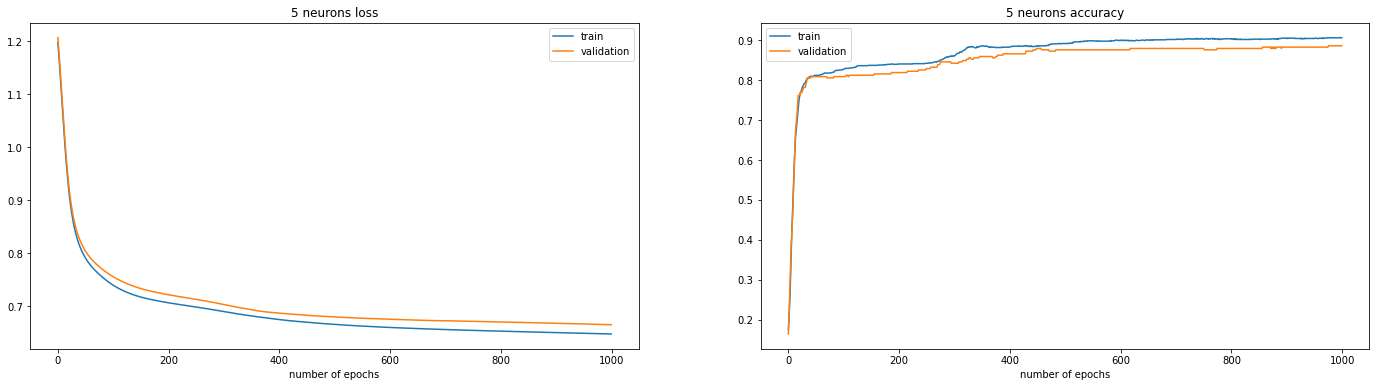

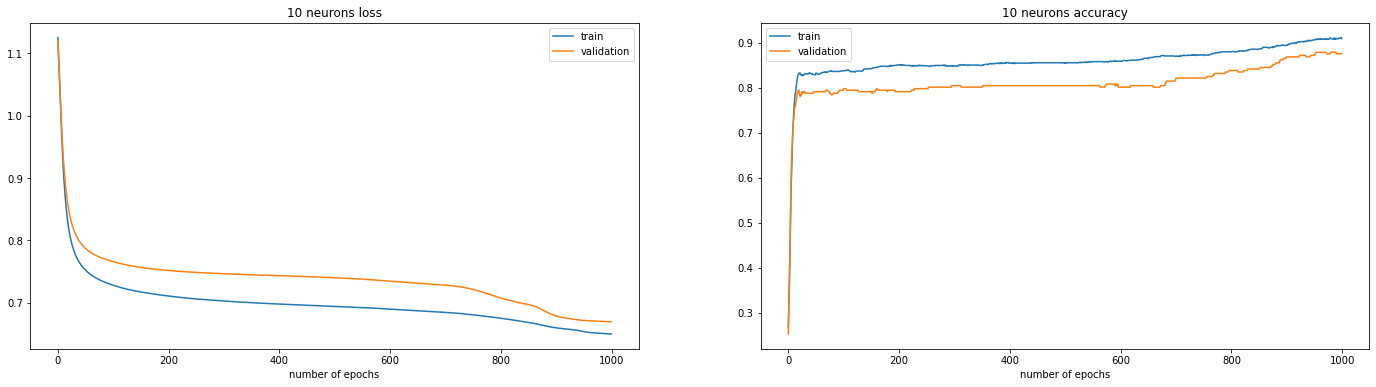

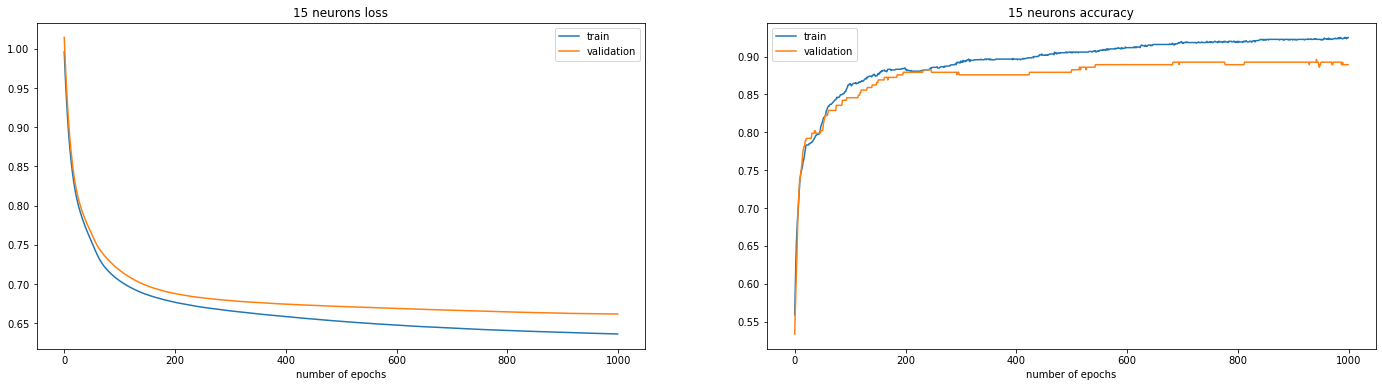

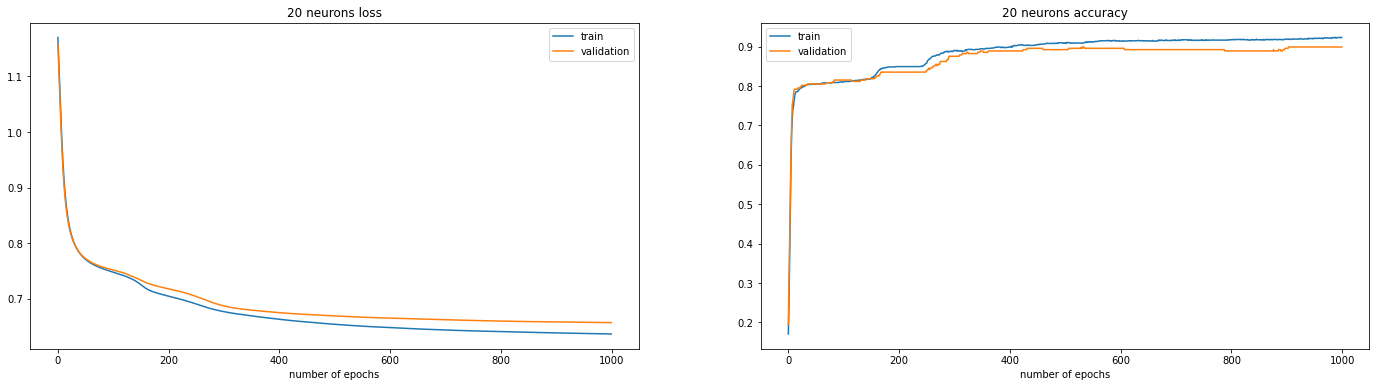

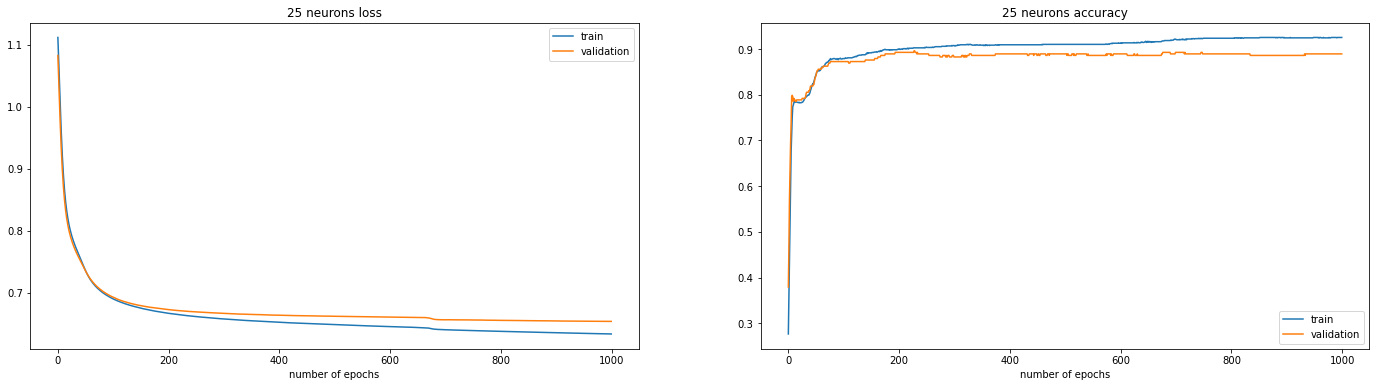

In [98]:
# plot loss and accuracy curves
for num_neurons, info in num_neurons_info.items():   
    history = info['history'].history
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title(f'{num_neurons} neurons loss')
    
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='validation')
    
    loss_axis.legend()
    loss_axis.set_xlabel('number of epochs')

    accuracy_axis.set_title(f'{num_neurons} neurons accuracy')
    
    accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='validation')
    
    accuracy_axis.legend()
    accuracy_axis.set_xlabel('number of epochs')

    plt.savefig(f'output/a_3a_num_neurons_{num_neurons}.png')

print()

b) Select the optimal number of neurons for the hidden layer. State the rationale for
your selection.

Hard to tell based on the loss curves. I will just go with the one that leads highest accuracy (25), even though it is not higher by a lot.

c) Plot the train and test accuracies against epochs with the optimal number of neurons.

In [99]:
optimal_num_neurons = 25

In [100]:
# get model
model = get_3_layer_nn(optimal_num_neurons, weight_decay_parameter)

In [101]:
# train model on entire training set
model, history, results = train_early_stop(
    model,
    train_features,
    train_labels,
    test_features,
    test_labels,
    batch_size=optimal_batch_size,
)

del model

10/10 [==============================] - 0s 1ms/step - loss: 0.6619 - accuracy: 0.8887


In [102]:
# check evaluation scores
print_results(results)

test loss: 0.6619, test accuracy: 0.8887
number of epochs to reach minimum test error: 4700


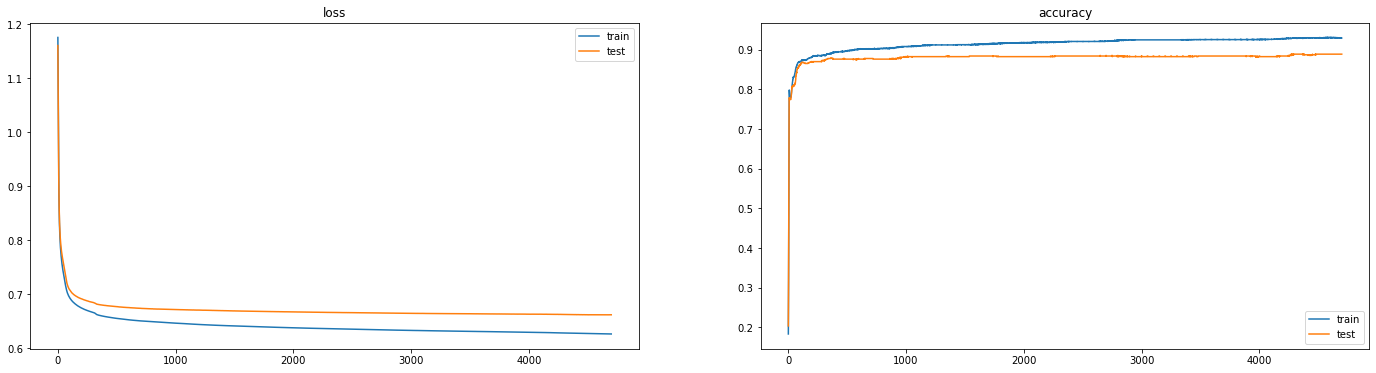

In [103]:
plot_loss_accuracy_curves(results['num_epochs'], history, 'output/a_3c.png')

del results
del history

4. Find the optimal decay parameter for the 3-layer network designed with optimal hidden neurons in part (3).

a) Plot cross-validation accuracies against the number of epochs for the 3-layer network for different values of decay parameters. Limit the search space of decay parameters to {0, 10<sup>-3</sup>, 10<sup>-6</sup>, 10<sup>-9</sup>, 10<sup>-12</sup>}.

In [104]:
# training params

decay_params = [0, 10**-3, 10**-6, 10**-9, 10**-12]

In [105]:
decay_params_info = {decay_param: {} for decay_param in decay_params}

for decay_param in decay_params:
    print(f'trying out decay parameter of {decay_param}')

    best_fold = 0
    best_results = {'loss': 1, 'accuracy': 0}
    best_history = None

    # 5-fold cross validation using training set
    splits = kfold.split(train_features, train_labels)
    
    for fold_index, (train_indices, val_indices) in enumerate(splits):
        print(f'working on fold {fold_index}')
        model = get_3_layer_nn(optimal_num_neurons, decay_param)

        train_features_subset = train_features.iloc[train_indices]
        train_labels_subset = train_labels.iloc[train_indices]

        val_features = train_features.iloc[val_indices]
        val_labels = train_labels.iloc[val_indices]

        train_history = model.fit(
            x=train_features_subset,
            y=train_labels_subset,
            batch_size=optimal_batch_size,
            epochs=num_epochs,
            verbose=0,  # not showing training details
            validation_data=(val_features, val_labels),
            shuffle=True,
        )

        results = model.evaluate(
            test_features,
            test_labels,
            batch_size=optimal_batch_size,
            return_dict=True,
        )

        if results['accuracy'] > best_results['accuracy']:
            best_fold = fold_index
            best_model = model
            best_results = results
            best_history = train_history

    loss = best_results['loss']
    accuracy = best_results['accuracy']
    print(f'best fold: {best_fold}, loss: {loss:.4f}, accuracy: {accuracy:.4f}')
    
    decay_params_info[decay_param]['model'] = best_model
    decay_params_info[decay_param]['results'] = results
    decay_params_info[decay_param]['history'] = best_history

trying out decay parameter of 0
working on fold 0
10/10 [==============================] - 0s 1ms/step - loss: 0.6666 - accuracy: 0.8824
working on fold 1
10/10 [==============================] - 0s 1ms/step - loss: 0.6615 - accuracy: 0.8918
working on fold 2
10/10 [==============================] - 0s 993us/step - loss: 0.6624 - accuracy: 0.8934
working on fold 3
10/10 [==============================] - 0s 1ms/step - loss: 0.6749 - accuracy: 0.8793
working on fold 4
10/10 [==============================] - 0s 1ms/step - loss: 0.7198 - accuracy: 0.8292
best fold: 2, loss: 0.6624, accuracy: 0.8934
trying out decay parameter of 0.001
working on fold 0
10/10 [==============================] - 0s 988us/step - loss: 0.7381 - accuracy: 0.8276
working on fold 1
10/10 [==============================] - 0s 995us/step - loss: 0.6825 - accuracy: 0.8903
working on fold 2
10/10 [==============================] - 0s 1000us/step - loss: 0.6785 - accuracy: 0.8966
working on fold 3
10/10 [=============

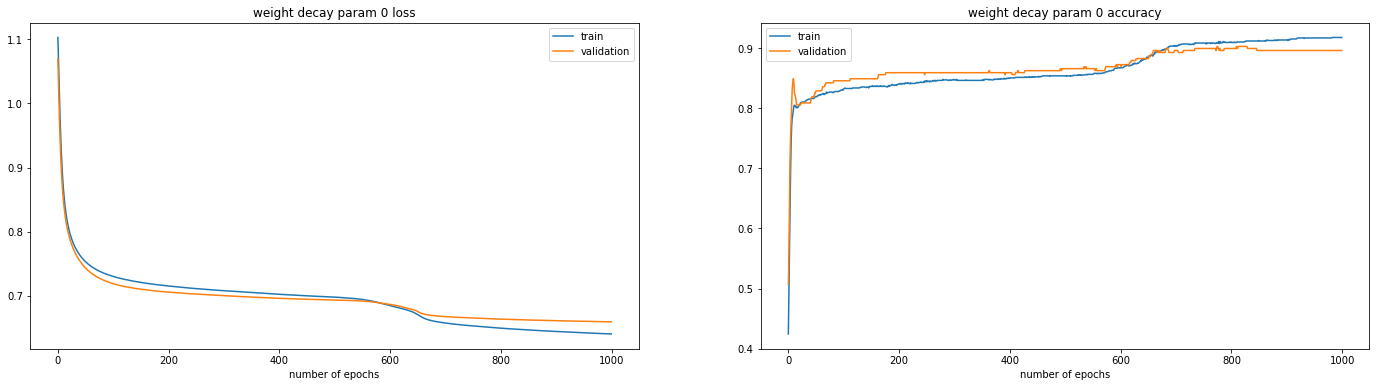

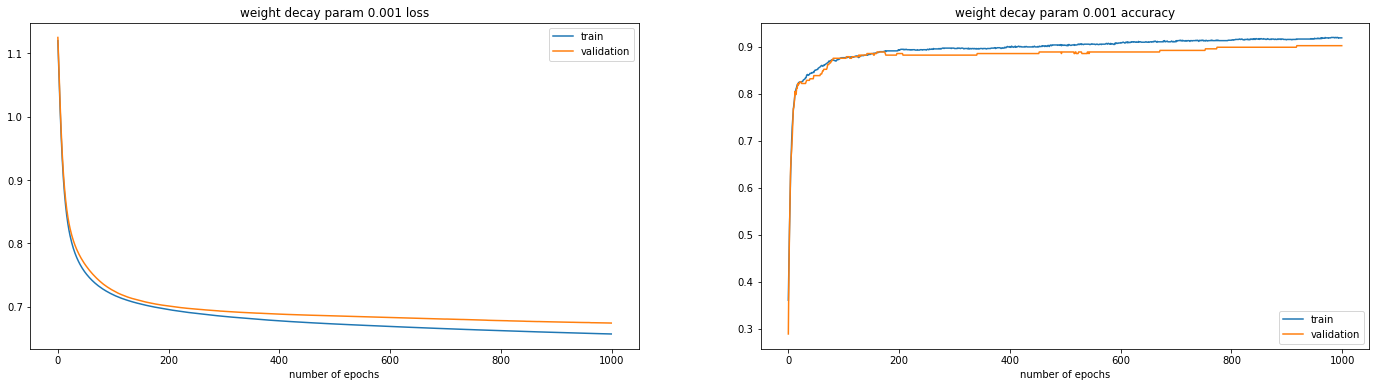

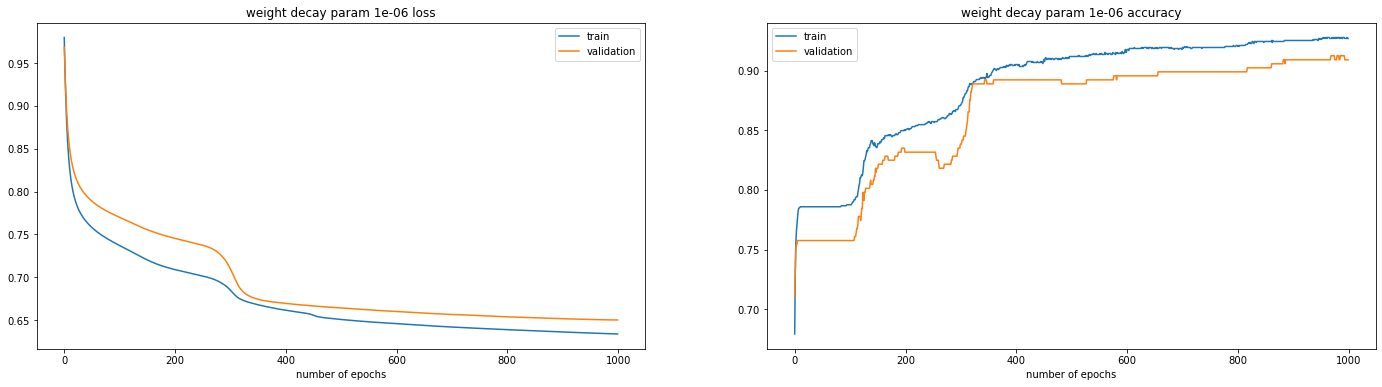

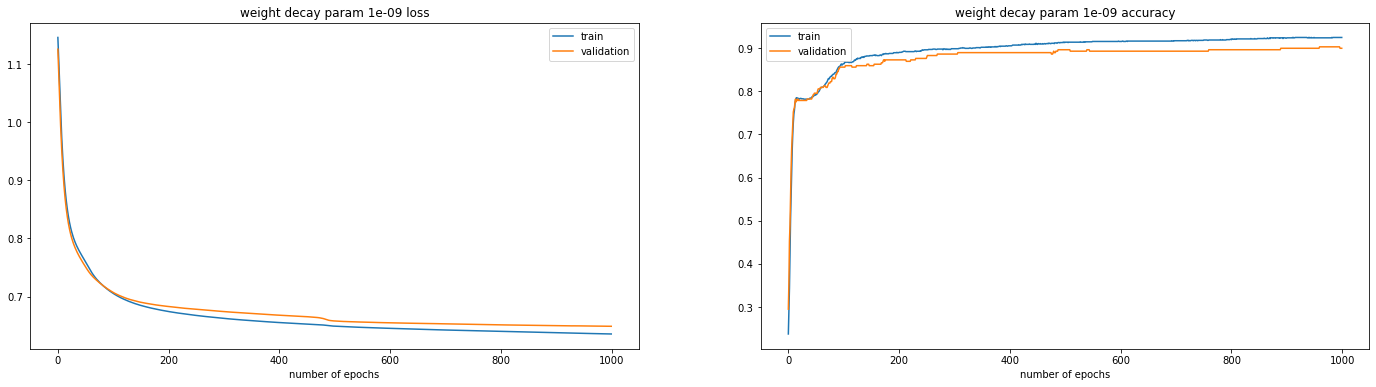

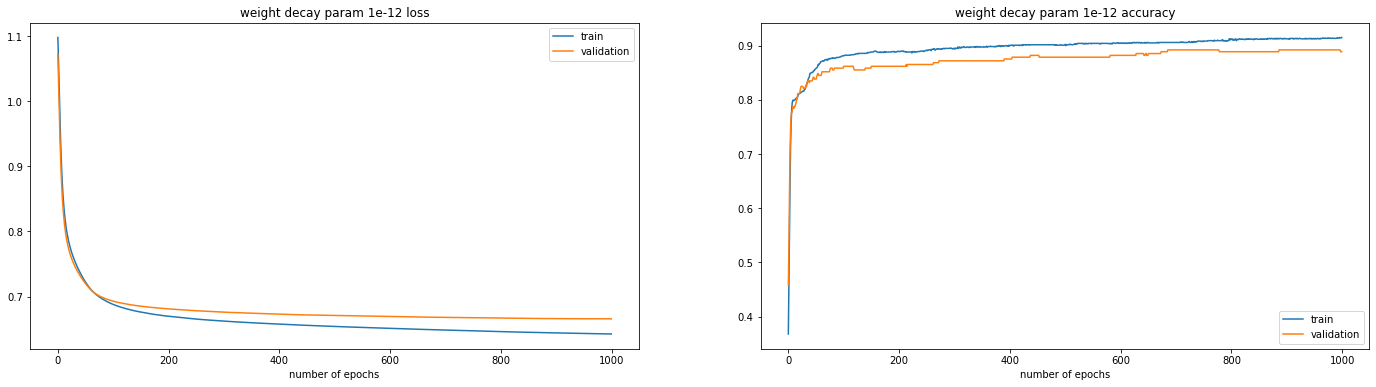

In [106]:
# plot loss and accuracy curves
for decay_param, info in decay_params_info.items():   
    history = info['history'].history
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title(f'weight decay param {decay_param} loss')
    
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='validation')
    
    loss_axis.legend()
    loss_axis.set_xlabel('number of epochs')

    accuracy_axis.set_title(f'weight decay param {decay_param} accuracy')
    
    accuracy_axis.plot(range(num_epochs), history['accuracy'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_accuracy'], label='validation')
    
    accuracy_axis.legend()
    accuracy_axis.set_xlabel('number of epochs')
    
    plt.savefig(f'output/a_4a_decay_param_{decay_param}.png')

print()

b) Select the optimal decay parameter. State the rationale for your selection.

I do not really see any pattern based on the loss curves (e.g. larger weight decay reduces likelihood of overfitting). I would go with one of the weight decays that led to the 'best' looking loss curve - 10<sup>-3</sup>.

c) Plot the train and test accuracies against epochs for the optimal decay parameter.

In [107]:
optimal_weight_decay = 10**-3

In [108]:
# get model
model = get_3_layer_nn(optimal_num_neurons, optimal_weight_decay)

In [109]:
# train model on entire training set
model, history, results = train_early_stop(
    model,
    train_features,
    train_labels,
    test_features,
    test_labels,
    batch_size=optimal_batch_size,
)

del model

10/10 [==============================] - 0s 1ms/step - loss: 0.6487 - accuracy: 0.9201


In [110]:
# check evaluation scores
print_results(results)

test loss: 0.6487, test accuracy: 0.9201
number of epochs to reach minimum test error: 6200


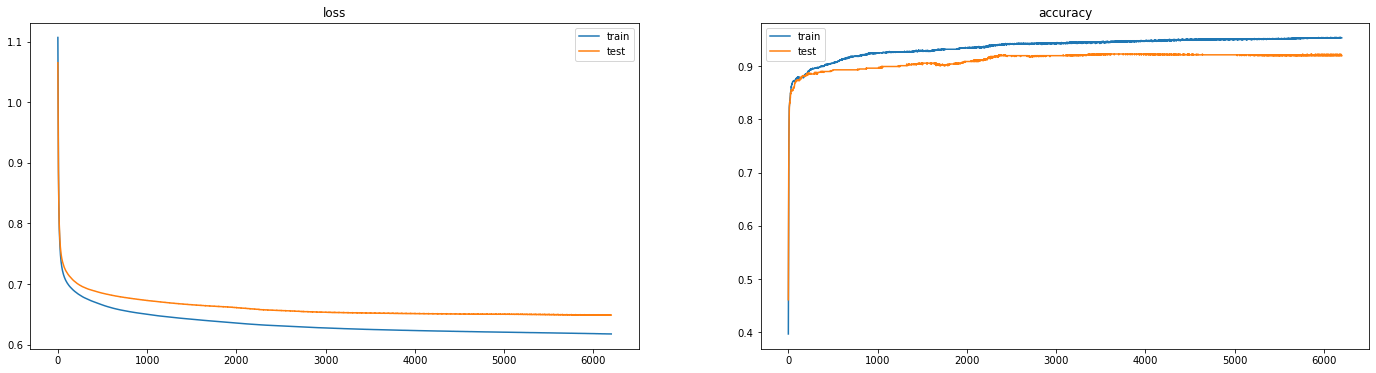

In [111]:
plot_loss_accuracy_curves(results['num_epochs'], history, 'output/a_4c.png')

del results
del history

5. After you are done with the 3-layer network, design a 4-layer network with two hidden-layers, each consisting 10 neurons, and train it with a batch size of 32 and decay parameter 10<sup>-6</sup>.

In [112]:
def get_4_layer_nn(num_neurons: int, decay_param: float) -> tf.keras.Sequential:
    '''
    Generates a 4-layer fully-connected neural network.
        layer 1 - input layer
        layer 2 - hidden layer
        layer 3 - hidden layer
        layer 4 - output layer (softmax)

    :params:
    - num_neurons (int): number of neurons in the hidden layer
    - decay_params (float): weight decay parameter for L_2 loss

    :return:
    - (tf.keras.Sequential)
    '''
    input_layer = tf.keras.layers.InputLayer(
        input_shape=num_features,
    )

    hidden_layer_1 = tf.keras.layers.Dense(
        num_neurons,
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.l2(l=decay_param),
    )
    
    hidden_layer_2 = tf.keras.layers.Dense(
        num_neurons,
        activation=hidden_activation,
        kernel_regularizer=tf.keras.regularizers.l2(l=decay_param),
    )

    output_layer = tf.keras.layers.Dense(
        num_classes,
        activation='softmax',
    )

    model = tf.keras.Sequential([
        input_layer,
        hidden_layer_1,
        hidden_layer_2,
        output_layer,
    ])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=['accuracy'],
    )

    return model

In [113]:
# get model
model = get_4_layer_nn(10, 10**-6)
model.summary()

Model: "sequential_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_321 (Dense)            (None, 10)                220       
_________________________________________________________________
dense_322 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_323 (Dense)            (None, 3)                 33        
Total params: 363
Trainable params: 363
Non-trainable params: 0
_________________________________________________________________


In [114]:
# train model on entire training set
model, history, results = train_early_stop(
    model,
    train_features,
    train_labels,
    test_features,
    test_labels,
)

del model

20/20 [==============================] - 0s 1ms/step - loss: 0.6497 - accuracy: 0.8966


In [115]:
# check evaluation scores
print_results(results)

test loss: 0.6497, test accuracy: 0.8966
number of epochs to reach minimum test error: 1650


a) Plot the train and test accuracy of the 4-layer network.

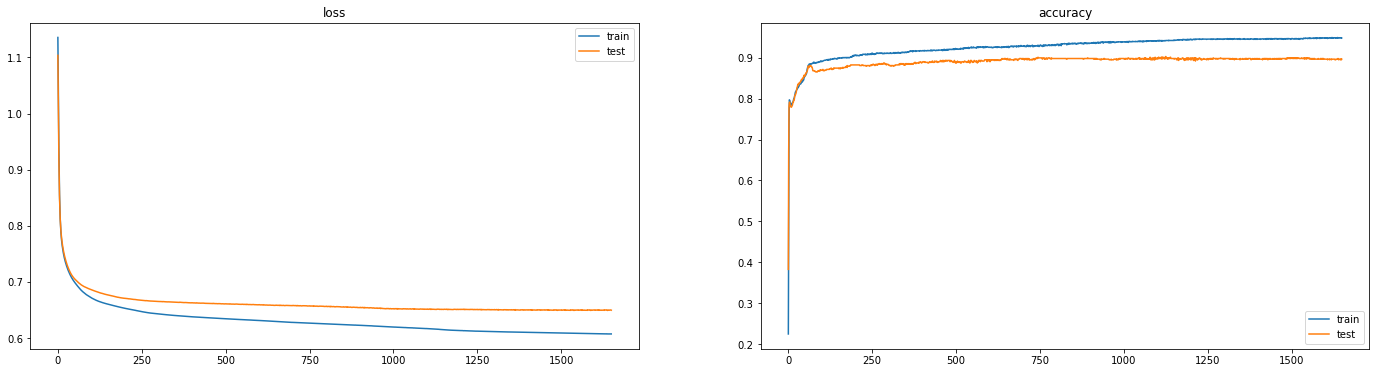

In [116]:
plot_loss_accuracy_curves(results['num_epochs'], history, 'output/a_5a.png')

del results
del history

b) Compare and comment on the performances of the optimal 3-layer and 4-layer networks.

The additional layer should allow the 4-layer model to learn more about the data, leading to better accuracy as compared to a 3-layer model. However, we can see that that is not the case when the 3-layer model is tuned, but the 4-layer one isn't, which goes to show the importance of parameter tuning.